# Imports

In [96]:

import sys
sys.path.append('/../')
import numpy as np
import matplotlib.pyplot as plt
import traveltime as tt
import pinv
import copy
from scipy.io import loadmat

import gstools as gs  # to fit variograms
from scipy.ndimage import gaussian_filter  # for blurring



%matplotlib inline


# for reloading submodules without restarting kernel
%load_ext autoreload
%autoreload 2

# ignore plot warnings in gstools
import warnings
warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

This notebook gives some hints in terms of how to approach the assignement and get to grips with the PINV package. 

Please note the PINV package is a not a finished package, it is still under development by T. Meier-Hansen so some variables and functions in the package are not finished or some parts are hard-coded in the source code. However, the package contains all the functions and variable settings needed to solve the assignment. It is highly recommended that you walk though the tutorial notebooks first, they are very much relevant, and you may well get stuck if you do not look at these first.

Additionally, it can be a good idea to look in the "sippi.pdf" file in literature folder, as it provides explanations of similar variables in the MATLAB version of the package and the naming convention has been kept the same. So a strategy for understanding a function or variable below could be (in prioritized order):
- Search for the function/variable name or slight variations in "sippi.pdf", "Hansen_etal_2013_SIPPI1.pdf" and "Hansen_etal_2013_SIPPI2.pdf". Read! 
- Experiment with a small number of iterations and see which effect different variables have
- Look into source code (search function in VScode is very helpful here), but keep in mind that this requires reading the code - it does not have a lot of comments. Specifically line 107-132 in ```extended_metropolis.py``` provides a bit of insight into what order things are called in.

Make sure you can run everything below and make some test diagnostic plots before you start to run a large number of iterations (this can take a long time!). Note that you can load the hdf5 files after the run has completed, so if you run the model and later want to look at results you can load them from the hdf5, instead of running everything again. 

# Load data

In [97]:

M=loadmat('data/BHRS_2D.mat')
data_obs = M['traveltimes'].squeeze()
data_std = M['traveltimes_std'].squeeze()
ndata, ndim = M['sources'].shape
sources = M['sources'].squeeze()
receivers = M['receivers'].squeeze()

dx = .25
dy = dx
min_x = np.min(M['sources'][:, 0])
max_x = np.max(M['receivers'][:, 0])
min_y = np.min(np.hstack((M['sources'][:, 1],  M['receivers'][:, 1])))
max_y = np.max(np.hstack((M['sources'][:, 1],  M['receivers'][:, 1])))


# Setup prior

The prior is set up by assigning various fields to the prior object. First we assign a name and the type of prior we want to use, let us us the Cholesky method which is based on a cholesky decomposition of the covariance model.

In [98]:
# Get Prior 
# Load prior
P=loadmat('data/BHRS_prior.mat')

# The prior has a very small scale structure, that is finer than the resolution we apply. This fine structure will not affect the total travel time nor the total water contest. It however effects the variance and variogram. Because of this blurring is applied tu supress the fine stucture.
P["prior_0_blurred"] = gaussian_filter(P["prior_0"], sigma=1)
P["prior_1_blurred"] = gaussian_filter(P["prior_1"], sigma=1)
P["prior_2_blurred"] = gaussian_filter(P["prior_2"], sigma=1)

# Get the empirical variogram of the priors
bin_center_0, gamma_0 = gs.vario_estimate((P["x"], P["y"]), P["prior_0_blurred"])
bin_center_1, gamma_1 = gs.vario_estimate((P["x"], P["y"]), P["prior_1_blurred"])
bin_center_2, gamma_2 = gs.vario_estimate((P["x"], P["y"]), P["prior_2_blurred"])
# Combigning the variograms. The Gamma values can be averaged (like 3 scaled histograms). It helps especially with the larger distances where there are fewer available points
gamma_all = np.average(np.array([gamma_0, gamma_1, gamma_2]), axis=0)

In [99]:
# Save properties of prior: 
pri_values = np.array([P[f"prior_0_blurred"], P[f"prior_1_blurred"],P[f"prior_2_blurred"]]).flatten()
mean_pri = np.mean(pri_values)
h_pri=6.5  # Eyeballed it based on the variogram shape I don't know how van we fit it better 
# var_pri= np.var(pri_values)
var_pri= 8.5e-6 # I modified it at a higher value because the model this is the value of the variogram after it flattens out

In [100]:
# set up the prior generator, with the size of given priors:
im = 0
prior = [{}]
prior[im]['name'] = 'Cholesky, velocity (m/ns)'
prior[im]['method'] = 'cholesky'

d = dx # pixel size for the comparison. We can increase it for final run, but this eats RAM like crazy 
prior[im]['x'] = np.arange(0, 20 + d, d)
prior[im]['y'] = np.arange(0 , 20 + d, d)
domain_shape = (len(prior[im]['y']), len(prior[im]['x']))  # for reshaping later

# Set properties of prior model:
prior[im]['m0'] = mean_pri
prior[im]['Cm'] = '{} Sph({})'.format(var_pri, h_pri)

PINV[0/1]: init: Initializing prior #0 of type 'cholesky'


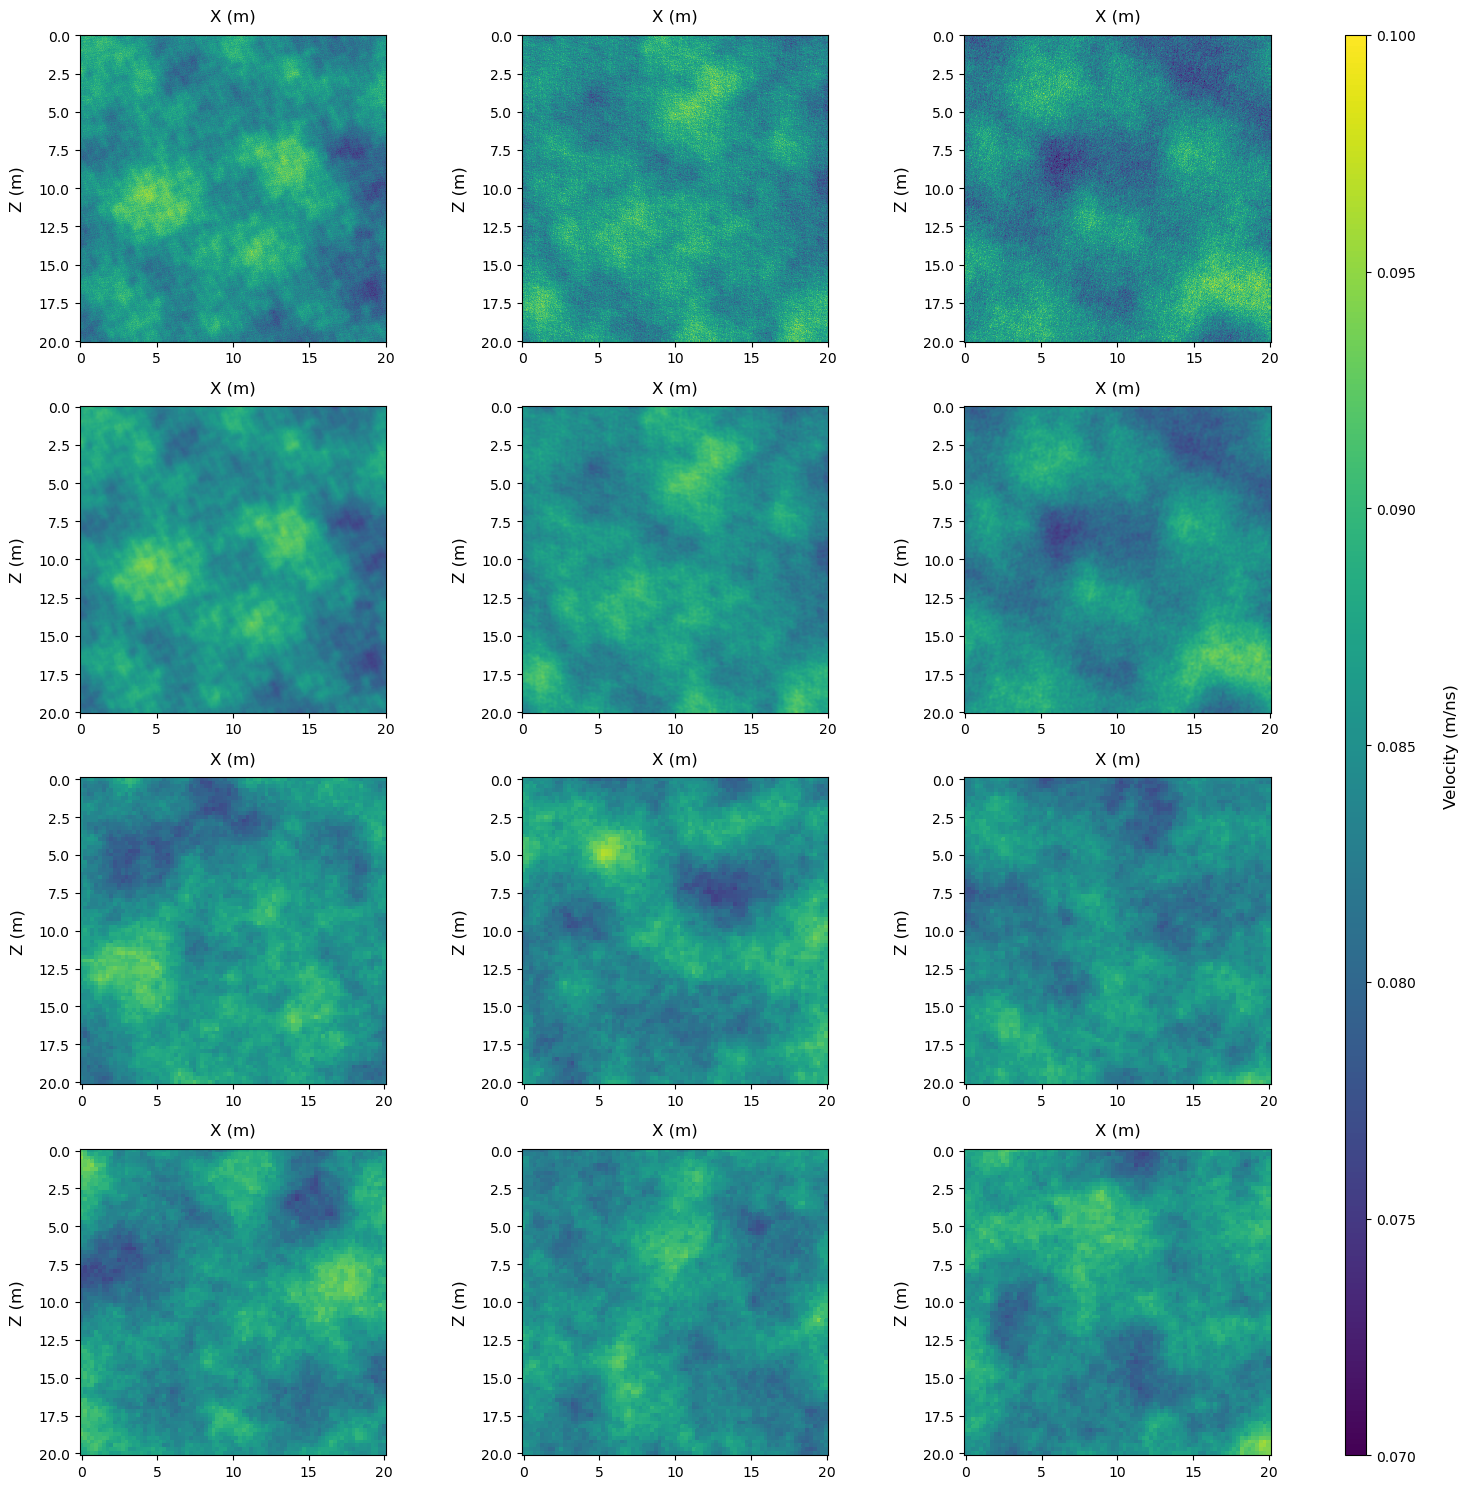

In [101]:
# original priors (first row), blurred priors(second row), example realizations of prior model (last 2 row)
fig = plt.figure(figsize=(15, 15))
grs = fig.add_gridspec(4, 4, width_ratios=[10, 10, 10, 0.5])  # Create a grid with space for colorbar
# Creating subplots
axs = [[None] * 3 for _ in range(4)]
for i in range(4):
    for j in range(3):
        axs[i][j] = fig.add_subplot(grs[i, j])
        if i == 0: axs[i][j].pcolor(P['x'][0], P['y'][0], P[f"prior_{j}"], vmin=0.07, vmax=0.1)
        elif i == 1: axs[i][j].pcolor(P['x'][0], P['y'][0], P[f"prior_{j}_blurred"], vmin=0.07, vmax=0.1)

        else: 
            m = pinv.prior.simulate(prior) # realisations of velocities from prior distribution
            axs[i][j].pcolor(prior[im]['x'], prior[im]['y'], m[0], vmin=0.07, vmax=0.1)
        axs[i][j].set_aspect('equal')
        axs[i][j].xaxis.set_label_position('top')
        axs[i][j].invert_yaxis()
        axs[i][j].set_xlabel('X (m)', fontsize=12, labelpad=10)
        axs[i][j].set_ylabel('Z (m)', fontsize=12, labelpad=10)

# Adding a single colorbar for all subplots
cbar_ax = fig.add_subplot(grs[:, 3])
cbar = fig.colorbar(axs[0][0].collections[0], cax=cbar_ax)
cbar.set_label('Velocity (m/ns)', fontsize=12, labelpad=20)

plt.tight_layout()
plt.show()

In [102]:
# get some realizations for the statistics
N = 50
gamma_sim = np.zeros((N, 14)) #TODO: second value needs to be adjusted when changing resolution
rel_values = np.array([])
for i in range(N):
    m = pinv.prior.simulate(prior) # realisations of velocities from prior distribution
    bin_center_sim, gamma_sim[i] = gs.vario_estimate((prior[im]['x'], prior[im]['y']), m[0])
    real_values = np.append(rel_values, m[0].flatten())

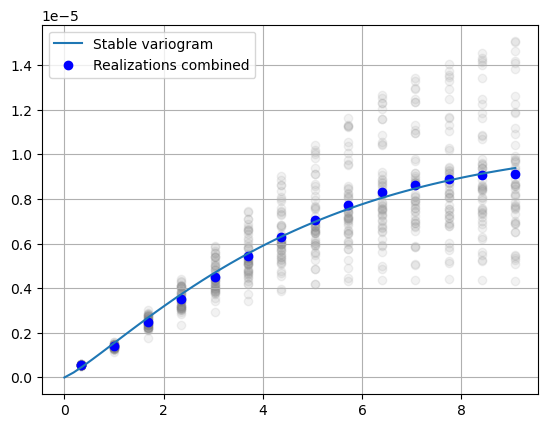

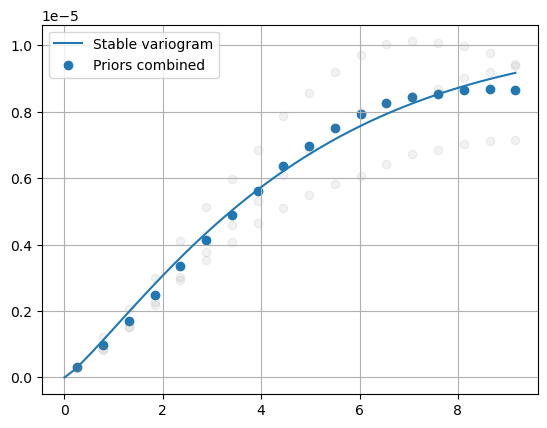

In [103]:
# We could plot all variances
gamma_sim_all = np.average(gamma_sim, axis=0)


fit_model_sim = gs.Stable(dim=2)
fit_model_sim.fit_variogram(bin_center_sim, gamma_sim_all, nugget=False)
ax = fit_model_sim.plot(x_max=max(bin_center_sim))
# Plotting average gamma_sim_all
for i in range(len(gamma_sim)):
    ax.scatter(bin_center_sim, gamma_sim[i],color="gray", alpha=0.1)
    # ax.scatter(bin_center_sim, gamma_sim[i], alpha=0.2, label=f'Realization {i+1}')
ax.scatter(bin_center_sim, gamma_sim_all, color="blue", label='Realizations combined')


ax.grid()
ax.legend()
plt.show()

# Variogram of priors
fit_model_pri = gs.Stable(dim=2)
fit_model_pri.fit_variogram(bin_center_0, gamma_all, nugget=False)
ax = fit_model_pri.plot(x_max=max(bin_center_0))
# Plotting scatter points for individual gamma values
# ax.scatter(bin_center_0, gamma_0, alpha=0.2, label='Prior 0')
# ax.scatter(bin_center_1, gamma_1, alpha=0.2, label='Prior 1')
# ax.scatter(bin_center_2, gamma_2, alpha=0.2, label='Prior 2')
ax.scatter(bin_center_0, gamma_0, color="gray", alpha=0.2)
ax.scatter(bin_center_1, gamma_1, color="gray", alpha=0.2)
ax.scatter(bin_center_2, gamma_2, color="gray", alpha=0.2)
ax.scatter(bin_center_0, gamma_all, color="blue", label='Priors combined')
ax.grid()
ax.legend()
plt.show()

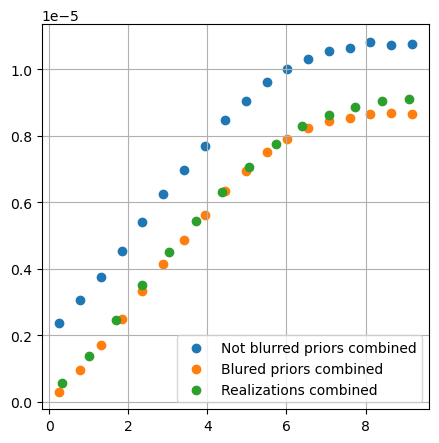

In [113]:
bin_center_0, gamma_0_og = gs.vario_estimate((P["x"], P["y"]), P["prior_0"])
bin_center_1, gamma_1_og = gs.vario_estimate((P["x"], P["y"]), P["prior_1"])
bin_center_2, gamma_2_og = gs.vario_estimate((P["x"], P["y"]), P["prior_2"])
# Combigning the variograms. The Gamma values can be averaged (like 3 scaled histograms). It helps especially with the larger distances where there are fewer available points
gamma_all_og = np.average(np.array([gamma_0_og, gamma_1_og, gamma_2_og]), axis=0)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.scatter(bin_center_0, gamma_all_og, label='Not blurred priors combined')
ax.scatter(bin_center_0, gamma_all, label='Blured priors combined')
ax.scatter(bin_center_sim, gamma_sim_all, label='Realizations combined')
ax.grid()
ax.legend()
plt.show()

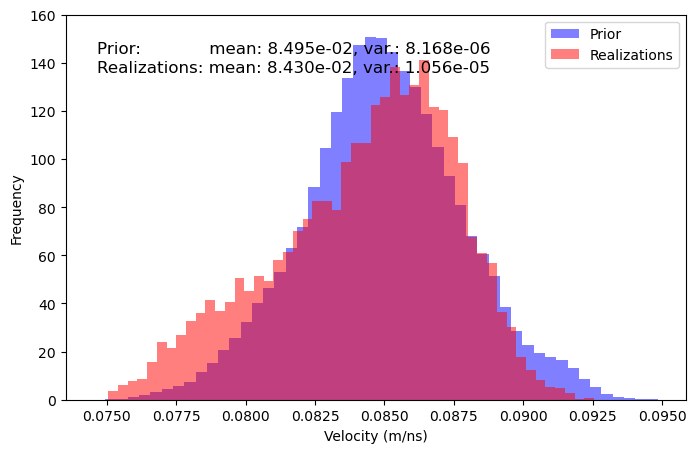

In [114]:
# Plotting the histograms
plt.figure(figsize=(8, 5))
plt.hist(pri_values, bins=50, color='blue', alpha=0.5, density=True, label='Prior')
plt.hist(real_values, bins=50, color='red', alpha=0.5, density=True, label='Realizations')
plt.xlabel('Velocity (m/ns)')
plt.ylabel('Frequency')
plt.ylim(0, 160)

# Calculating mean and variance for both datasets
prior_mean = np.mean(pri_values)
prior_var = np.var(pri_values)
realization_mean = np.mean(real_values)
realization_var = np.var(real_values)

# Adding labels indicating mean and variance
plt.text(0.05, 0.9,  f'Prior:             mean: {prior_mean:.3e}, var.: {prior_var:.3e}', transform=plt.gca().transAxes, fontsize=12)
plt.text(0.05, 0.85, f'Realizations: mean: {realization_mean:.3e}, var.: {realization_var:.3e}', transform=plt.gca().transAxes, fontsize=12)


plt.legend()
plt.show()

In [106]:
# Modify the domain of the prior model:

prior[im]['x'] = np.arange(min_x - 2 * dx, max_x + 2 * dx, dx)
prior[im]['y'] = np.arange(min_y - 2 * dy, max_y + 2 * dy, dy)
domain_shape = (len(prior[im]['y']), len(prior[im]['x']))  # for reshaping later

# Setup forward

In [107]:

##%% SETUP FORWARD
forward = {}
forward['S'] = M['sources'][:, 0:2]
forward['R'] = M['receivers'][:, 0:2]
forward['function'] = 'forward_traveltime'


# Setup data

In [108]:

##%% SETUP DATA
data=[{}]
data[0]['d_obs']=data_obs
data[0]['d_std']=data_std


# Test setup

In [109]:

##%% TEST SETUP
m = pinv.prior.simulate(prior) # realisations of velocities from prior distribution
d = pinv.forward.forward(m,forward,prior)
logL = pinv.likelihood(d,data)
print('LogL(g(m)) = %6.3f' % (logL[0]) )


ValueError: x and y must have equal lengths for non rectangular grid

## Plot model and rays

In [ ]:

##%% PLOT MODEL and RAYS
plt.figure(figsize=(7, 7))
plt.pcolor(prior[im]['x'], prior[im]['y'], m[0])
plt.gca().set_aspect('equal')
plt.gca().xaxis.set_label_position('top') 
for i in range(ndata):
    plt.plot([sources[i,0], receivers[i,0]], [sources[i,1], receivers[i,1]], 'w-', linewidth=0.2)
plt.gca().invert_yaxis()
plt.xlabel('X (m)', fontsize=15, labelpad=10)
plt.ylabel('Z (m)', fontsize=15, labelpad=10)
cbar = plt.colorbar()
cbar.set_label('Velocity (m/ns)', fontsize=15, labelpad=20)
plt.show()


## Plot data predictions from single forward pass

In [ ]:

plt.figure(figsize=(9, 5))
plt.plot(d[0], label='Data prediction from one forward pass')
plt.plot(data_obs, label='Observed data')
plt.ylabel('Traveltimes (ns)')
plt.xlabel('Datum #')
plt.legend()
plt.grid('grey')
plt.show()


# Do Metropolis sampling

In [ ]:

##%% SETUP METROPOLIS
mcmc={}
mcmc["n_ite"]=5000  # Too short - just for illustration!
#mcmc["n_ite"]=25000 # Longer but still too short?
mcmc["n_sample"]=100  # number of realizations to store
mcmc["i_plot"]=100  # plotting option, not working
mcmc['i_progress']=250 # how often progress should be updated

# Update step
mcmc['i_update_step']=50; # how often step length is adjusted
mcmc['i_update_step_max']=int(mcmc["n_ite"]/5); # for how long will the step length be updated
prior[0]['step_min']=0.001; # minimum step length


In [ ]:

pinv.verbose_level=2  # verbosity level, does not affect model, only print updates

mcmc_out = pinv.sampling.metropolis_chains(copy.deepcopy(forward), copy.deepcopy(prior), copy.deepcopy(data), mcmc)

# Might report error saving stricts using "deepdish" (which copies deep python structures), this is not a problem for this assignment

# Plot results

## Plot log-likelihood

In [ ]:

pinv.plot.plot_likelihood(mcmc_out['hdf5filename'])


## Plot acceptance rate

In [ ]:

pinv.plot.plot_acceptance_rate(mcmc_out['hdf5filename'])


## Plot acceptance rate histogram

In [ ]:

# The chain is not saved in mcmc variable but stored in hdf5 file
import h5py
f = h5py.File(mcmc_out['hdf5filename'], 'r')

# Acc rate is computed as an avg acc rate for a window of maximum 200 indices on each side of the current bin (bins of size 10, "n_ite" = 1000 gives 100 bins)
wi = 100
di = 10
v = 'C%d/i_acc' % 0
i_acc=f[v][im,:]

N=len(i_acc)
i_range=np.arange(0, N, di)
accrate = np.zeros(len(i_range))
k=0
for i in i_range:
    i1 = np.max([0, i - wi])
    i2 = np.min([N, i + wi])
    accrate[k] = np.sum(i_acc[i1:i2])/(i2-i1)
    k=k+1
    
fig = plt.figure(figsize=(9, 5))
plt.hist(accrate)
plt.show()


## Plot random posterior samples

In [ ]:

# Get posterior sample from saved outputs
m_all = pinv.sampling.get_sample_from_hdf5(mcmc_out['hdf5filename'], im=0, ic=0, nskip=0)

# Plot sequence of output models from posterior sample
random_index = np.random.randint(0, 100, 9)
m_plot = m_all[random_index]

fig = plt.figure(figsize=(10,10))
for i, posterior_sample in enumerate(m_plot):
    ax = fig.add_subplot(3, 3, i + 1) # this line adds sub-axes
    ax.imshow(posterior_sample.reshape(domain_shape))
plt.show()
